In [1]:
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import numpy as np

### Testing the number of GPU

In [2]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
print(f"Number of GPU: { strategy.num_replicas_in_sync }")

Number of GPU: 2


### Reading the DATA

In [5]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearnin/DATASETS/CatsVsDogs/cats_vs_dogs_small/')

In [6]:
tr_d = image_dataset_from_directory(
    w_dir / 'train',
    image_size=(180,180),
)

va_d = image_dataset_from_directory(
    w_dir / 'validation',
    image_size=(180,180),
)

te_d = image_dataset_from_directory(
    w_dir / 'test',
    image_size=(180,180),
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

tr_d = tr_d.prefetch(buffer_size=AUTOTUNE)
va_d = va_d.prefetch(buffer_size=AUTOTUNE)
te_d = te_d.prefetch(buffer_size=AUTOTUNE)

### importing and freezing VGG16

In [5]:
# conv_base = keras.applications.vgg16.VGG16(
#     include_top=False,
#     weights='imagenet'
# )

# # Freezing
# conv_base.trainable = False

### Augmentation

In [8]:
data_augmentation = keras.Sequential( 
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

### Model

In [9]:
with strategy.scope():
    inputs = keras.Input(shape=(180,180,3))

    x = data_augmentation(inputs)

    # instantiating VGG16
    conv_base = keras.applications.vgg16.VGG16(
        include_top=False,
        weights='imagenet'
    )

    # Freezing
    conv_base.trainable = False

    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)

    # our Classifier
    x = layers.Flatten()(x)

    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

### Training

In [10]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='CatsVsDogsPreTrainedWithAugmentation.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    
    # To monitoring the training on TensorBoard
    keras.callbacks.TensorBoard(
        log_dir='/home/antirrabia/Documents/DeepLearnin/Notebooks/TensorBoard_Logs/'
    )
]

history = model.fit(
    tr_d,
    epochs=52,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/52
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/tas

### Ploting the training

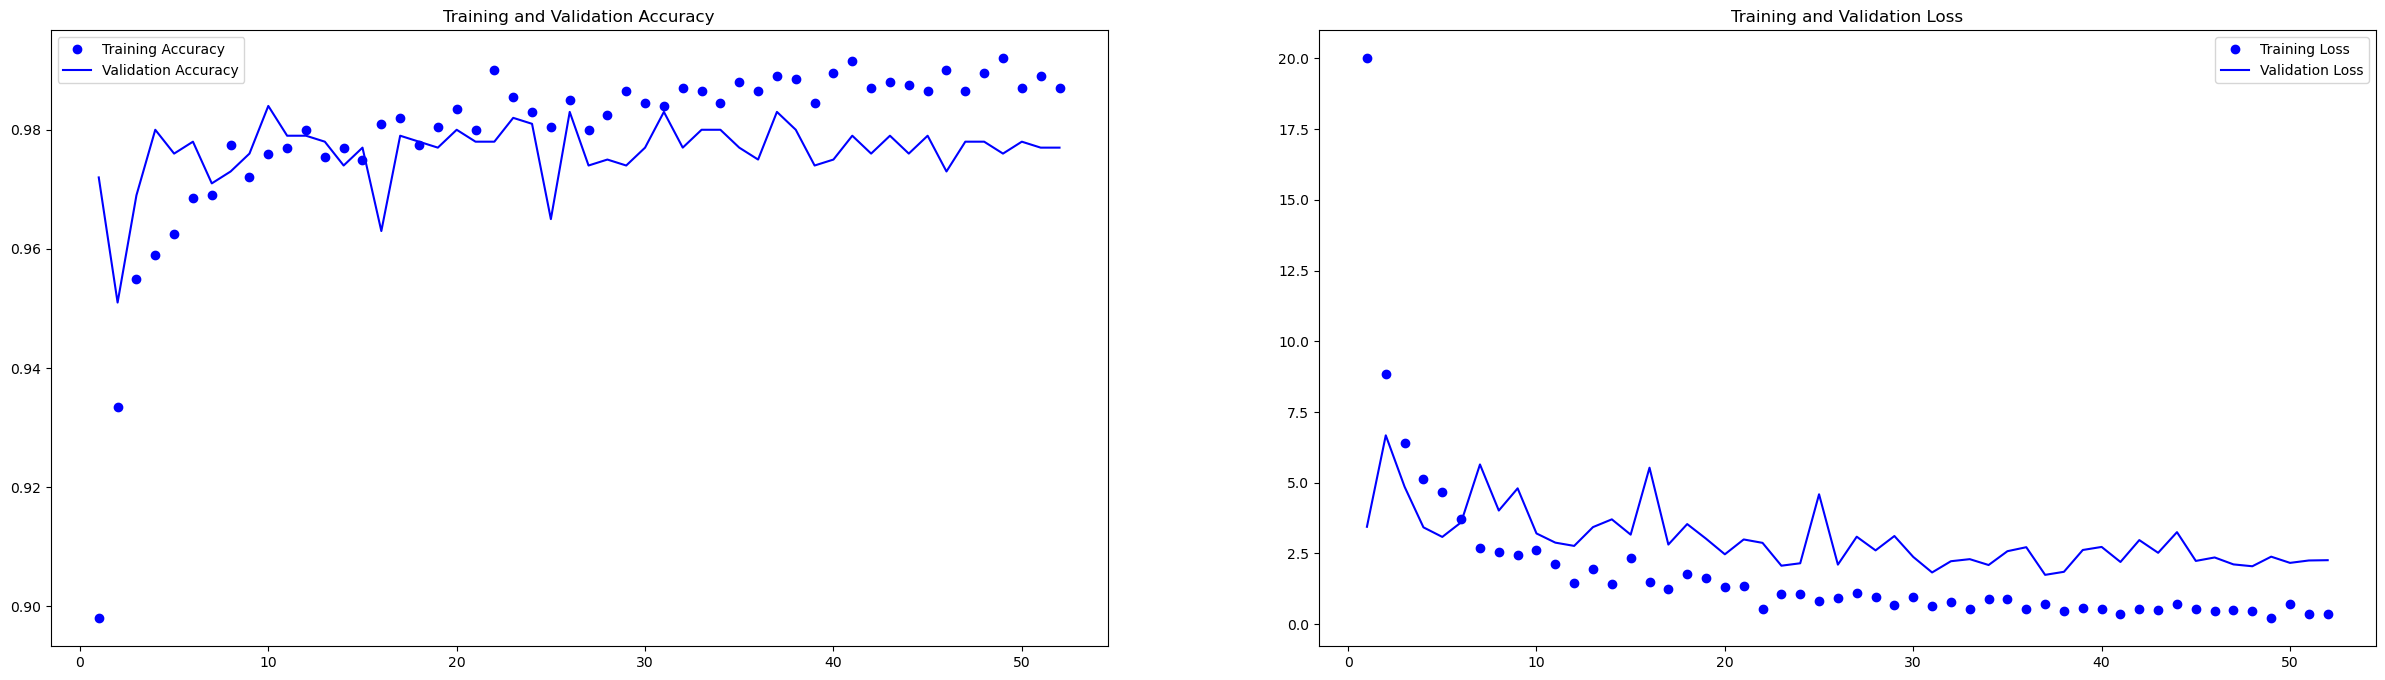

In [11]:
# Accuracy
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,8))

ax[0].plot(epochs, accuracy, 'ob', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()
